# Analisi delle varianti di Rprop per la classificazione del dataset MNIST
Il presente quaderno Jupyter fornisce un ambiente interattivo per l'esplorazione e l'addestramento di reti neurali per il riconoscimento delle cifre del dataset MNIST. Con questo quaderno, gli utenti possono:


### Sperimentare con diverse configurazioni di Reti Neurali
Il quaderno offre la flessibilità di sperimentare con una vasta gamma di configurazioni di reti neurali. Gli utenti possono definire il numero di strati nascosti, il numero di neuroni per strato e le funzioni di attivazione desiderate per costruire la loro rete neurale.


### Personalizzare i parametri di addestramento
Gli utenti possono personalizzare i parametri di addestramento come il numero di epoche, il tasso di apprendimento e la suddivisione del set di addestramento. Inoltre, possono specificare il numero di run, ovvero quante volte desiderano ripetere l'addestramento per una determinata configurazione di rete e algoritmo di ottimizzazione.


### Testare diversi algoritmi di ottimizzazione Rprop
Il quaderno include implementazioni di diversi algoritmi di ottimizzazione, tra cui varianti di Rprop come Rprop-, Rprop+, iRprop-, e iRprop+. Gli utenti possono confrontare le prestazioni delle reti neurali addestrate con questi diversi algoritmi di ottimizzazione.


### Valutare le Prestazioni delle Reti Neurali
Il quaderno fornisce un'analisi dettagliata delle prestazioni delle reti neurali addestrate, inclusi l'errore sui set di addestramento e di validazione, l'accuratezza sui set di addestramento, di validazione e di test e il tempo di esecuzione. Inoltre, vengono calcolate la media e la varianza delle metriche di prestazione su più run, consentendo agli utenti di valutare la stabilità e la consistenza delle configurazioni di rete e algoritmi di ottimizzazione.


## Contenuti
1. Estrazione e preparazione del dataset MNIST
2. Creazione delle reti neurali originarie
3. Addestramento delle reti neurali con diverse varianti di Rprop
4. Valutazione delle prestazioni attraverso grafici
5. Test delle reti addestrate su immagini del test set


N.B: la variabile *number_of_runs* deve essere maggiore di 0.


In [6]:
# Funzione utilizzata successivamente per il calcolo delle medie e delle varianze delle metriche considerate
def metrics_mean_variance(metrics_list, epochs, number_of_runs):
    
    numbers_of_metrics = len(metrics_list[0])
    metrics_mean = [[] for _ in range(numbers_of_metrics)]
    metrics_variance = [[] for _ in range(numbers_of_metrics)]
    
    for metric in range(numbers_of_metrics - 1):
        for epoch in range(epochs + 1):
            metric_mean, metric_variance = 0, 0
            for run in range(number_of_runs):
                # Calcola la media per questa epoca e questa metrica attraverso tutte le run
                metric_mean += metrics_list[run][metric][epoch] / number_of_runs
            # Aggiungo la media alla lista delle medie della metrica corrispondente
            metrics_mean[metric].append(metric_mean)
            
            for run in range(number_of_runs):
                # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
                metric_variance += pow(metrics_list[run][metric][epoch] - metric_mean, 2) / number_of_runs
            # Calcola la varianza normalizzata rispetto alla media, per poter confrontare reti diverse
            norm_variance = metric_variance / metric_mean
            # Aggiunge la media alla lista delle medie della metrica corrispondente
            metrics_variance[metric].append(norm_variance)
    
    time_mean, time_variance = 0, 0
    for run in range(number_of_runs):
        # Calcola la media dei tempi di esecuzione di tutte le run
        time_mean += metrics_list[run][-1] / number_of_runs
    metrics_mean[-1] = time_mean
    
    for run in range(number_of_runs):
        # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
        time_variance += pow(metrics_list[run][-1] - time_mean, 2) / number_of_runs
    metrics_variance[-1] = time_variance
    
    # Prende l'ultima media di ogni metrica che rappresenta l'ultima epoca
    last_metrics_mean = [round(metric_mean[-1], 5) if isinstance(metric_mean, list) else round(metric_mean, 5) for metric_mean in metrics_mean]
    
    # Prende l'ultima varianza di ogni metrica che rappresenta l'ultima epoca
    last_metrics_variance = [round(metric_variance[-1], 5) if isinstance(metric_variance, list) else round(metric_variance, 5) for metric_variance in metrics_variance]
    
    metrics = ["Train Error", "Validation Error", "Train Accuracy", "Validation Accuracy", "Time"]
    
    # Stampa delle metriche raggruppate per media e varianza
    for metric, mean, var in zip(metrics, last_metrics_mean, last_metrics_variance):
        print(f"{metric}:")
        print(f"Media: {mean}")
        print(f"Varianza: {var}")
        print()
        
    return metrics_mean, metrics_variance, last_metrics_mean, last_metrics_variance

In [7]:
from uninaannpy import neural_network as nn
from uninaannpy import error_functions as ef
from uninaannpy import activation_functions as af
from uninaannpy import datasets as ds

import numpy as np
import pandas as pd

# Legge csv con pandas
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

# Ottiene array per il training e il test
train_array = np.array(train_data)
test_array = np.array(test_data)

# Estrapola il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

# Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcola percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

# Distribuzione training, validation e test set
train_X, train_Y = ds.get_mnist_training(train_array, val_index)
validation_X, validation_Y = ds.get_mnist_validation(train_array, val_index)
test_X, test_Y = ds.get_mnist_test(test_array)

In [8]:
## Creazione rete neurale

# Assegna funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [af.leaky_relu]

# Assegna numero di neuroni per ogni strato
hidden_layers = [128]
#Assegna della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = af.identity
error_function = ef.cross_entropy_softmax

# Estrae dimensione input e target
input_layer_size = train_X.shape[0]
output_layer_size = train_Y.shape[0]

epochs = 35
learning_rate = 0.00001
number_of_runs = 10 # Deve essere maggiore di 0!

nets = []

for i in range(number_of_runs):
    hidden_activation_functions = [hidden_activation_functions[0]]
    net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)
    nets.append(net)

In [9]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
std_metrics_list = []
std_trained_nets = []

for i in range(number_of_runs):
    std_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training Rprop standard
    std_metrics = std_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.STANDARD)
    std_trained_nets.append(std_training_net)
    std_metrics_list.append(std_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.05506,       Training Loss: 117177.82698;
    Validation Accuracy: 0.05392,     Validation Loss: 29327.68553


Epoca: 1/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.12075,       Training Loss: 108330.1732;
    Validation Accuracy: 0.11393,     Validation Loss: 27089.28026


Epoca: 2/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.20115,       Training Loss: 192644.18342;
    Validation Accuracy: 0.20285,     Validation Loss: 47758.82818


Epoca: 3/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.26834,       Training Loss: 283159.46647;
    Validation Accuracy: 0.27269,     Validation Loss: 70268.99832


Epoca: 4/35   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.34957,       Training Loss: 261628.91761;
    Validation Accuracy: 0.3502,     Validation Loss: 65953.24595


Epoca: 5/35   Rprop utilizzata: RpropType.STANDA

In [10]:
import numpy as np

std_metrics_mean, std_metrics_variance, std_last_metrics_mean, std_last_metrics_variance = metrics_mean_variance(std_metrics_list, epochs, number_of_runs)

Train Error:
Media: 8379.84911
Varianza: 129.98148

Validation Error:
Media: 3005.90572
Varianza: 16.95585

Train Accuracy:
Media: 0.9486
Varianza: 5e-05

Validation Accuracy:
Media: 0.93548
Varianza: 3e-05

Time:
Media: 14.30364
Varianza: 0.60075



In [11]:
# Stampa accuracy per training e test set
std_test_accuracies = []
std_test_accuracy_mean, std_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    std_test_accuracies.append(std_trained_nets[run].print_accuracies(f'\nTest Rprop- Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
std_test_accuracy_mean = np.mean(std_test_accuracies)
# Calcola la varianza
std_test_accuracy_variance = np.var(std_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
std_test_accuracy_variance = std_test_accuracy_variance / std_test_accuracy_mean


Test Rprop- Run 1
Test accuracy: 0.94329
Train accuracy: 0.95479

Test Rprop- Run 2
Test accuracy: 0.93419
Train accuracy: 0.94079

Test Rprop- Run 3
Test accuracy: 0.94119
Train accuracy: 0.95227

Test Rprop- Run 4
Test accuracy: 0.93099
Train accuracy: 0.94071

Test Rprop- Run 5
Test accuracy: 0.93909
Train accuracy: 0.95231


In [12]:
# Costruzione della stringa per il file di output
csv_string_std = '0,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_std += str(number_of_runs) + ',' + ','.join(map(str, std_last_metrics_mean)) + ',' + ','.join(map(str, std_last_metrics_variance)) + f',{round(std_test_accuracy_mean, 5)},{round(std_test_accuracy_variance, 5)}\n'

In [13]:
from uninaannpy.neural_network import RpropType

# Inizializzo una lista vuota per memorizzare i risultati
plus_metrics_list = []
plus_trained_nets = []

for i in range(number_of_runs):
    plus_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training Rprop con weight-backtracking
    plus_metrics = plus_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.RPROP_PLUS)
    plus_trained_nets.append(plus_training_net)
    plus_metrics_list.append(plus_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.05506,       Training Loss: 117177.82698;
    Validation Accuracy: 0.05392,     Validation Loss: 29327.68553


Epoca: 1/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.12075,       Training Loss: 108330.1732;
    Validation Accuracy: 0.11393,     Validation Loss: 27089.28026


Epoca: 2/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.20546,       Training Loss: 193697.07573;
    Validation Accuracy: 0.20902,     Validation Loss: 47954.7821


Epoca: 3/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.33442,       Training Loss: 323860.20851;
    Validation Accuracy: 0.34045,     Validation Loss: 80595.0254


Epoca: 4/35   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.27257,       Training Loss: 448794.12427;
    Validation Accuracy: 0.26411,     Validation Loss: 113955.64079


Epoca: 5/35   Rprop utilizzata: RpropT

In [14]:
import numpy as np

plus_metrics_mean, plus_metrics_variance, plus_last_metrics_mean, plus_last_metrics_variance = metrics_mean_variance(plus_metrics_list, epochs, number_of_runs)

Train Error:
Media: 10011.23995
Varianza: 67.54383

Validation Error:
Media: 3295.46333
Varianza: 9.94118

Train Accuracy:
Media: 0.93741
Varianza: 3e-05

Validation Accuracy:
Media: 0.92596
Varianza: 2e-05

Time:
Media: 11.07402
Varianza: 0.07338



In [15]:
# Stampa accuracy per training e test set
plus_test_accuracies = []
plus_test_accuracy_mean, plus_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    plus_test_accuracies.append(plus_trained_nets[run].print_accuracies(f'\nTest Rprop+ Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
plus_test_accuracy_mean = np.mean(plus_test_accuracies)
# Calcola la varianza
plus_test_accuracy_variance = np.var(plus_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
plus_test_accuracy_variance = plus_test_accuracy_variance / plus_test_accuracy_mean


Test Rprop+ Run 1
Test accuracy: 0.93539
Train accuracy: 0.94656

Test Rprop+ Run 2
Test accuracy: 0.91999
Train accuracy: 0.93192

Test Rprop+ Run 3
Test accuracy: 0.92529
Train accuracy: 0.93608

Test Rprop+ Run 4
Test accuracy: 0.92689
Train accuracy: 0.93271

Test Rprop+ Run 5
Test accuracy: 0.93039
Train accuracy: 0.93977


In [16]:
# Costruzione della stringa per il file di output
csv_string_plus = '1,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_plus += str(number_of_runs) + ',' + ','.join(map(str, plus_last_metrics_mean)) + ',' + ','.join(map(str, plus_last_metrics_variance)) + f',{round(plus_test_accuracy_mean, 5)},{round(plus_test_accuracy_variance, 5)}\n'

In [17]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
istd_metrics_list = []
istd_trained_nets = []

for i in range(number_of_runs):
    istd_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training improved Rprop
    istd_metrics = istd_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP)
    istd_trained_nets.append(istd_training_net)
    istd_metrics_list.append(istd_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.05506,       Training Loss: 117177.82698;
    Validation Accuracy: 0.05392,     Validation Loss: 29327.68553


Epoca: 1/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.12075,       Training Loss: 108330.1732;
    Validation Accuracy: 0.11393,     Validation Loss: 27089.28026


Epoca: 2/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.20115,       Training Loss: 192644.18342;
    Validation Accuracy: 0.20285,     Validation Loss: 47758.82818


Epoca: 3/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.2824,       Training Loss: 279650.26018;
    Validation Accuracy: 0.28602,     Validation Loss: 69409.48374


Epoca: 4/35   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.30682,       Training Loss: 295861.45553;
    Validation Accuracy: 0.30228,     Validation Loss: 74538.43599


Epoca: 5/35   Rprop utilizzata: RpropType.IRPROP
    Train

In [18]:
import numpy as np

istd_metrics_mean, istd_metrics_variance, istd_last_metrics_mean, istd_last_metrics_variance = metrics_mean_variance(istd_metrics_list, epochs, number_of_runs)

Train Error:
Media: 8031.74615
Varianza: 39.49461

Validation Error:
Media: 3052.49621
Varianza: 3.33061

Train Accuracy:
Media: 0.95035
Varianza: 1e-05

Validation Accuracy:
Media: 0.93706
Varianza: 1e-05

Time:
Media: 11.51072
Varianza: 0.04295



In [19]:
# Stampa accuracy per training e test set
istd_test_accuracies = []
istd_test_accuracy_mean, istd_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    istd_test_accuracies.append(istd_trained_nets[run].print_accuracies(f'\nTest iRprop- Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
istd_test_accuracy_mean = np.mean(istd_test_accuracies)
# Calcola la varianza
istd_test_accuracy_variance = np.var(istd_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
istd_test_accuracy_variance = istd_test_accuracy_variance / istd_test_accuracy_mean


Test iRprop- Run 1
Test accuracy: 0.93249
Train accuracy: 0.94521

Test iRprop- Run 2
Test accuracy: 0.94009
Train accuracy: 0.94939

Test iRprop- Run 3
Test accuracy: 0.93879
Train accuracy: 0.9515

Test iRprop- Run 4
Test accuracy: 0.94089
Train accuracy: 0.95077

Test iRprop- Run 5
Test accuracy: 0.93859
Train accuracy: 0.95323


In [20]:
# Costruzione della stringa per il file di output
csv_string_istd = '2,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_istd += str(number_of_runs) + ',' + ','.join(map(str, istd_last_metrics_mean)) + ',' + ','.join(map(str, istd_last_metrics_variance)) + f',{round(istd_test_accuracy_mean, 5)},{round(istd_test_accuracy_variance, 5)}\n'

In [21]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
iplus_metrics_list = []
iplus_nets = []
iplus_trained_nets = []

for i in range(number_of_runs):
    iplus_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training improved Rprop con weight-backtracking
    iplus_metrics = iplus_training_net.train_neural_network(train_X, train_Y, validation_X, validation_Y, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP_PLUS)
    iplus_metrics_list.append(iplus_metrics)
    iplus_trained_nets.append(iplus_training_net)
    iplus_metrics_list.append(iplus_metrics)




Run numero 1 


Epoca: 0/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.05506,       Training Loss: 117177.82698;
    Validation Accuracy: 0.05392,     Validation Loss: 29327.68553


Epoca: 1/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.12075,       Training Loss: 108330.1732;
    Validation Accuracy: 0.11393,     Validation Loss: 27089.28026


Epoca: 2/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.20546,       Training Loss: 193697.07573;
    Validation Accuracy: 0.20902,     Validation Loss: 47954.7821


Epoca: 3/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.33442,       Training Loss: 323860.20851;
    Validation Accuracy: 0.34045,     Validation Loss: 80595.0254


Epoca: 4/35   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.27257,       Training Loss: 448794.12427;
    Validation Accuracy: 0.26411,     Validation Loss: 113955.64079


Epoca: 5/35   Rprop utilizzata: R

In [22]:
import numpy as np

iplus_metrics_mean, iplus_metrics_variance, iplus_last_metrics_mean, iplus_last_metrics_variance = metrics_mean_variance(iplus_metrics_list, epochs, number_of_runs)

Train Error:
Media: 9039.4388
Varianza: 554.75978

Validation Error:
Media: 3177.80196
Varianza: 69.70205

Train Accuracy:
Media: 0.94492
Varianza: 0.00017

Validation Accuracy:
Media: 0.93168
Varianza: 0.00011

Time:
Media: 11.40857
Varianza: 0.00974



In [23]:
# Stampa accuracy per training e test set
iplus_test_accuracies = []
iplus_test_accuracy_mean, iplus_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    iplus_test_accuracies.append(plus_trained_nets[run].print_accuracies(f'\nTest iRprop+ Run {run + 1}', test_X, test_Y, train_X, train_Y))
    
# Calcola la media
iplus_test_accuracy_mean = np.mean(iplus_test_accuracies)
# Calcola la varianza
iplus_test_accuracy_variance = np.var(iplus_test_accuracies)
# Calcola la varianza normalizzata rispetto alla media
iplus_test_accuracy_variance = iplus_test_accuracy_variance / iplus_test_accuracy_mean


Test iRprop+ Run 1
Test accuracy: 0.93539
Train accuracy: 0.94656

Test iRprop+ Run 2
Test accuracy: 0.91999
Train accuracy: 0.93192

Test iRprop+ Run 3
Test accuracy: 0.92529
Train accuracy: 0.93608

Test iRprop+ Run 4
Test accuracy: 0.92689
Train accuracy: 0.93271

Test iRprop+ Run 5
Test accuracy: 0.93039
Train accuracy: 0.93977


In [24]:
# Costruzione della stringa per il file di output
csv_string_iplus = '3,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_iplus += str(number_of_runs) + ',' + ','.join(map(str, iplus_last_metrics_mean)) + ',' + ','.join(map(str, iplus_last_metrics_variance)) + f',{round(iplus_test_accuracy_mean, 5)},{round(iplus_test_accuracy_variance, 5)}\n'

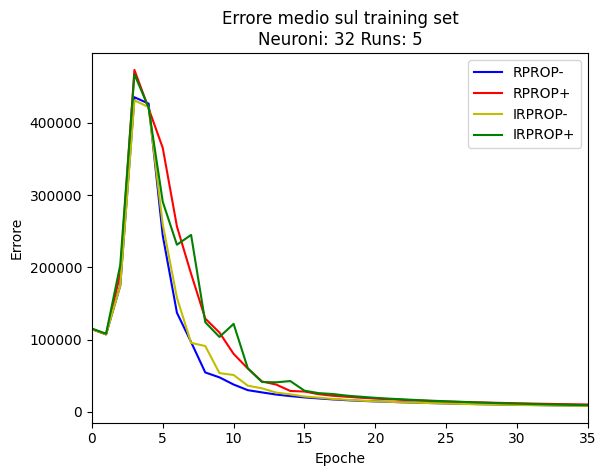

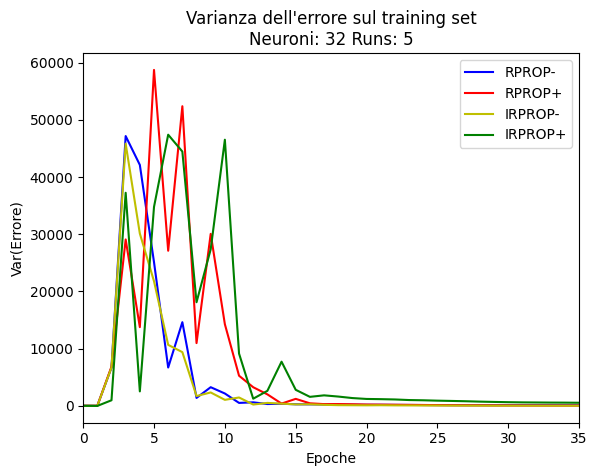

In [25]:
from matplotlib import pyplot as plt

# Stampo grafico dell'errore medio del train set
plt.figure()
plt.plot(std_metrics_mean[0], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[0], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[0], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[0], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title(f'Errore medio sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salvo il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_err_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampo grafico della varianza dell'errore del train set
plt.figure()
plt.plot(std_metrics_variance[0], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[0], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[0], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[0], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Errore)')
plt.title(f'Varianza dell\'errore sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salvo il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_err_var_{number_of_runs}runs.png')

plt.show()

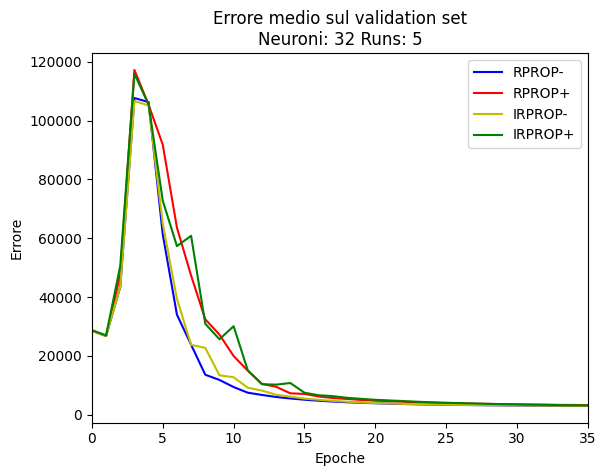

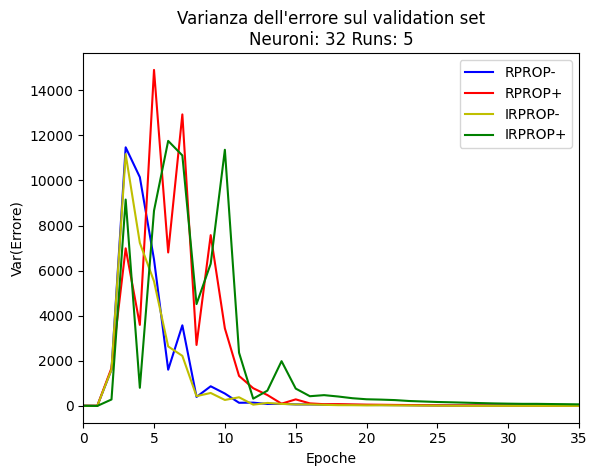

In [26]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore medio del validation set
plt.figure()
plt.plot(std_metrics_mean[1], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[1], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[1], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[1], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title(f'Errore medio sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_err_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'errore del validation set
plt.figure()
plt.plot(std_metrics_variance[1], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[1], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[1], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[1], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Errore)')
plt.title(f'Varianza dell\'errore sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_err_var_{number_of_runs}runs.png')

plt.show()

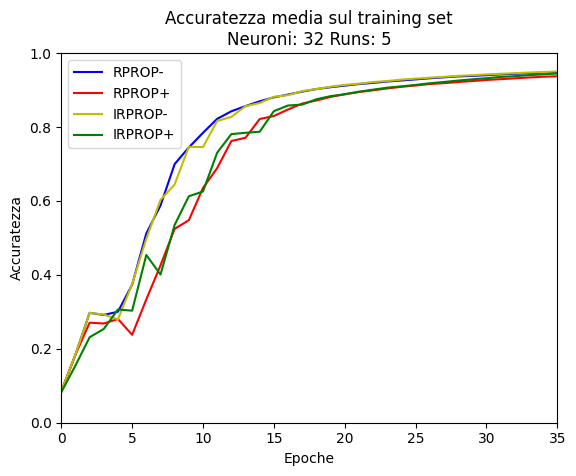

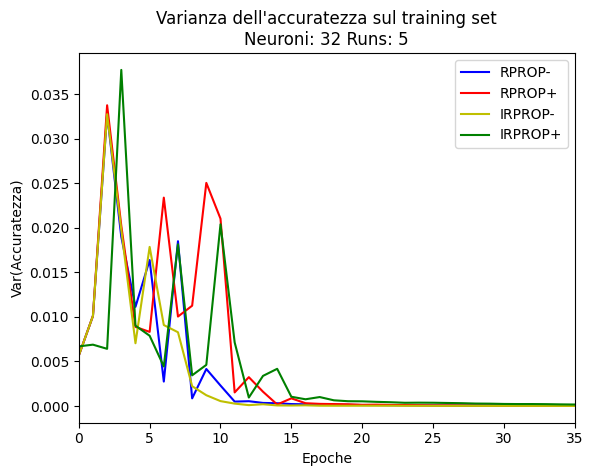

In [27]:
from matplotlib import pyplot as plt

# Stampa grafico dell'accuratezza media del train set
plt.figure()
plt.plot(std_metrics_mean[2], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[2], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[2], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[2], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title(f'Accuratezza media sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_acc_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'accuratezza del train set
plt.figure()
plt.plot(std_metrics_variance[2], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[2], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[2], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[2], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Accuratezza)')
plt.title(f'Varianza dell\'accuratezza sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_acc_var_{number_of_runs}runs.png')

plt.show()

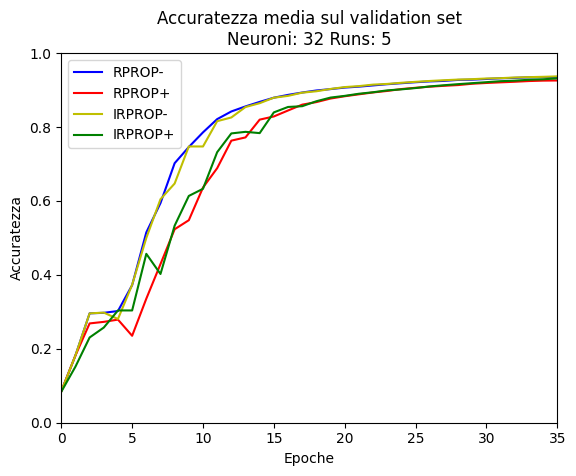

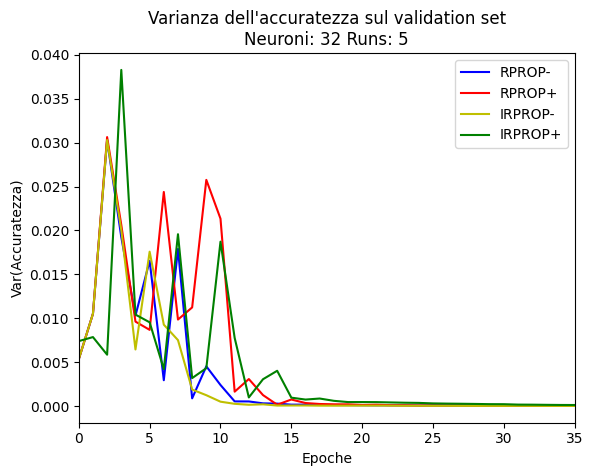

In [28]:
from matplotlib import pyplot as plt

# Stampa grafico dell'accuratezzaa media del validation set
plt.figure()
plt.plot(std_metrics_mean[3],  'b', label='RPROP-')
plt.plot(plus_metrics_mean[3], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[3], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[3], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title(f'Accuratezza media sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_acc_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'accuratezza del validation set
plt.figure()
plt.plot(std_metrics_variance[3],  'b', label='RPROP-')
plt.plot(plus_metrics_variance[3], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[3], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[3], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Accuratezza)')
plt.title(f'Varianza dell\'accuratezza sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_acc_var_{number_of_runs}runs.png')

plt.show()

In [29]:
# Scrive le stringhe nel CSV
with open("data/runs_mean_variance.csv", "a") as file:
     file.write(csv_string_std)
     file.write(csv_string_plus)
     file.write(csv_string_istd)
     file.write(csv_string_iplus)

Test Rprop-
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


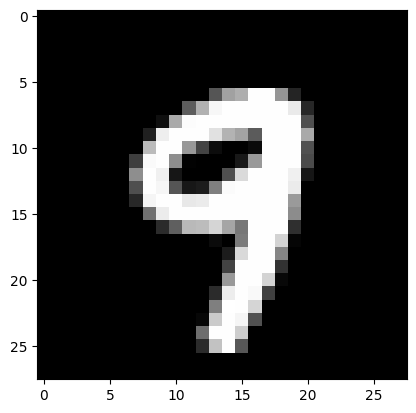

In [30]:
# Predizione rete addestrata con Rprop- (standard)
image = 8000

print('Test Rprop-')
std_training_net.test_prediction(image, test_X)

Test Rprop+
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


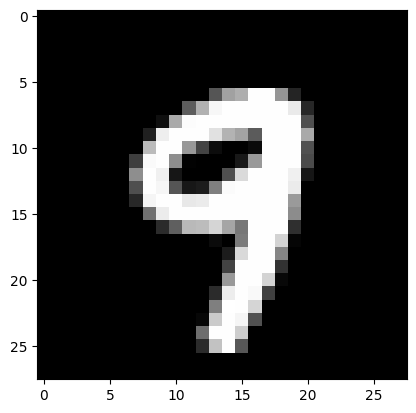

In [31]:
# Predizione rete addestrata con Rprop+ (Rprop con weight-backtracking)
image = 8000

print('Test Rprop+')
plus_training_net.test_prediction(image, test_X)

Test iRprop-
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


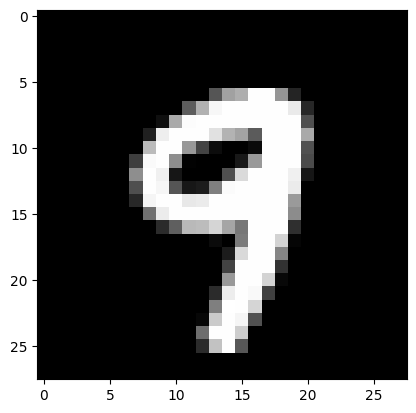

In [32]:
# Predizione rete addestrata con iRprop- (Improved Rprop)
image = 8000

print('Test iRprop-')
istd_training_net.test_prediction(image, test_X)

Test iRprop+
Probabilità predette dalla rete:
Classe 0: 0.0
Classe 1: 0.0
Classe 2: 0.0
Classe 3: 0.0
Classe 4: 0.0
Classe 5: 0.0
Classe 6: 0.0
Classe 7: 0.0
Classe 8: 0.0
Classe 9: 1.0


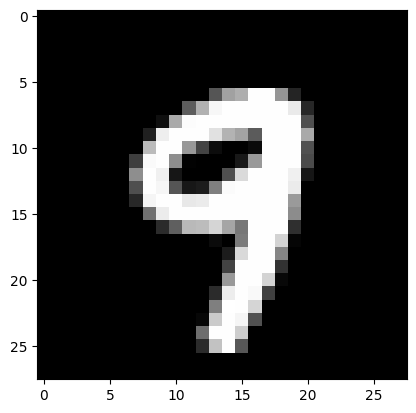

In [33]:
# Predizione rete addestrata con iRprop+ (Improved Rprop con weight-backtracking)
image = 8000

print('Test iRprop+')
iplus_training_net.test_prediction(image, test_X)